In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py, io
import os
import torch
from torch.utils.data import Dataset,DataLoader,Sampler
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import albumentations as A
from tqdm.notebook import tqdm_notebook as tqdm
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
import torchvision
import torchmetrics
from torchvision import datasets, models, transforms
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import warnings
import pickle
warnings.filterwarnings("ignore")
sns.set()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [ ]:
df = pd.read_csv('train-metadata.csv')

In [ ]:
df_test = pd.read_csv('test-metadata.csv')

In [ ]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

<Axes: >

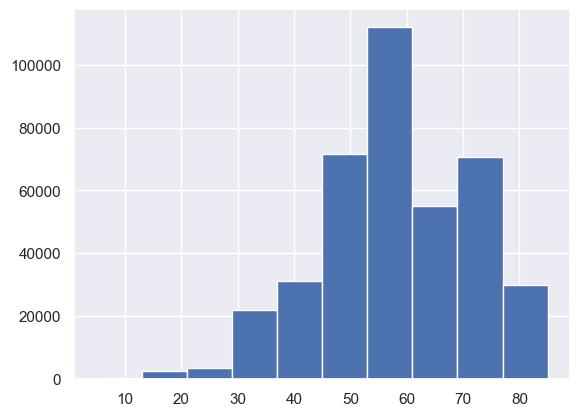

In [ ]:
df[df['target']==0]['age_approx'].hist()

<Axes: >

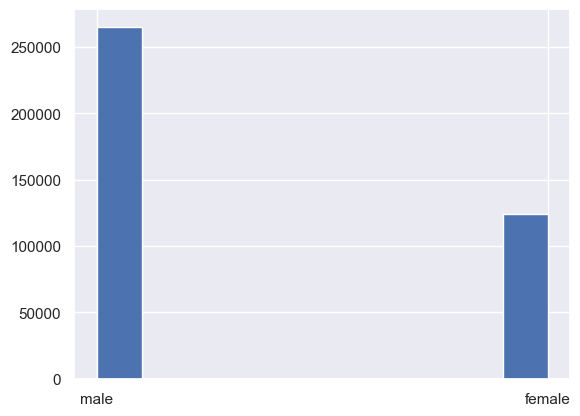

In [ ]:
df[df['target']==0]['sex'].hist()

In [ ]:
df['anatom_site_general'].value_counts(normalize = True)

anatom_site_general
posterior torso    0.308376
lower extremity    0.260630
anterior torso     0.222032
upper extremity    0.178488
head/neck          0.030473
Name: proportion, dtype: float64

In [ ]:
pd.crosstab(df['target'],df['anatom_site_general'])

anatom_site_general,anterior torso,head/neck,lower extremity,posterior torso,upper extremity
target,,,,,
0,87688,11968,102955,121799,70500
1,82,78,73,103,57


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

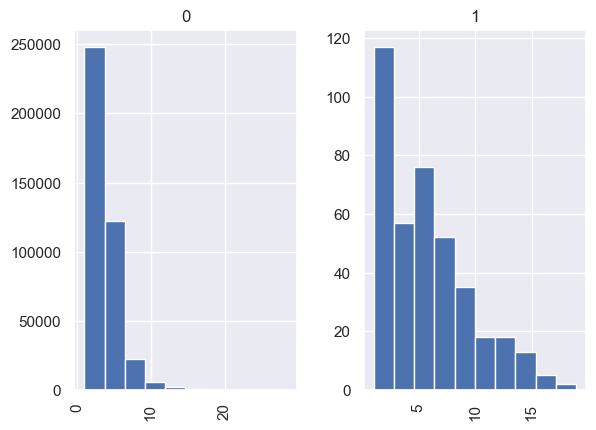

In [ ]:
df['clin_size_long_diam_mm'].hist(by = df['target'])

In [ ]:
pd.crosstab(df['target'],df['clin_size_long_diam_mm'])

clin_size_long_diam_mm,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.10,...,23.67,24.20,24.38,24.42,24.52,24.88,25.00,26.22,28.04,28.40
target,,,,,,,,,,,,,,,,,,,,,
0,8,2,2,11,31,1,4,22,1,144,...,1,1,1,1,1,1,1,1,1,1
1,0,1,0,0,0,0,0,2,0,9,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['image_type'].value_counts()

image_type
TBP tile: close-up    401059
Name: count, dtype: int64

In [ ]:
df['tbp_tile_type'].value_counts()

tbp_tile_type
3D: XP       285903
3D: white    115156
Name: count, dtype: int64

In [ ]:
pd.crosstab(df['target'], df['tbp_tile_type'])

tbp_tile_type,3D: XP,3D: white
target,,
0,285706,114960
1,197,196


In [ ]:
pd.crosstab(df['target'], df['tbp_lv_areaMM2'])

tbp_lv_areaMM2,0.431601,0.469131,0.487896,0.506662,0.525427,0.544192,0.544192,0.562957,0.581723,0.581723,...,202.345656,204.879000,206.436500,208.031526,210.508500,221.373616,221.974104,234.847100,284.481100,334.152700
target,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,2,3,1,1,3,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='tbp_lv_areaMM2', ylabel='clin_size_long_diam_mm'>

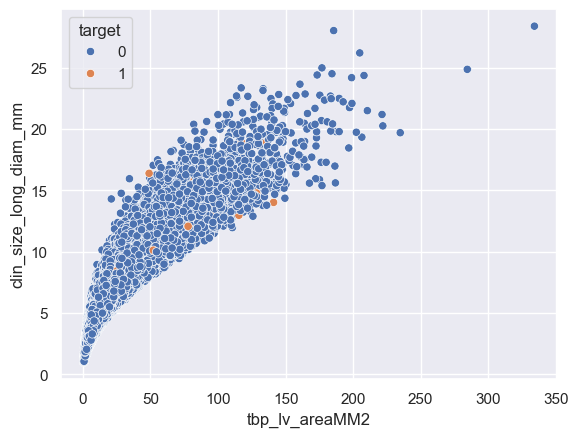

In [ ]:
sns.scatterplot(data = df, x = 'tbp_lv_areaMM2', y = 'clin_size_long_diam_mm', hue = 'target')

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
df.isnull().any()

isic_id                         False
target                          False
patient_id                      False
age_approx                       True
sex                              True
anatom_site_general              True
clin_size_long_diam_mm          False
image_type                      False
tbp_tile_type                   False
tbp_lv_A                        False
tbp_lv_Aext                     False
tbp_lv_B                        False
tbp_lv_Bext                     False
tbp_lv_C                        False
tbp_lv_Cext                     False
tbp_lv_H                        False
tbp_lv_Hext                     False
tbp_lv_L                        False
tbp_lv_Lext                     False
tbp_lv_areaMM2                  False
tbp_lv_area_perim_ratio         False
tbp_lv_color_std_mean           False
tbp_lv_deltaA                   False
tbp_lv_deltaB                   False
tbp_lv_deltaL                   False
tbp_lv_deltaLB                  False
tbp_lv_delta

In [ ]:
not_in_test = [cols for cols in df.columns if cols not in df_test]
not_in_test

['target',
 'lesion_id',
 'iddx_full',
 'iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'mel_mitotic_index',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence']

In [ ]:
df['iddx_1'].value_counts()

iddx_1
Benign           400552
Malignant           393
Indeterminate       114
Name: count, dtype: int64

In [ ]:
df['mel_mitotic_index'].value_counts()

mel_mitotic_index
0/mm^2     22
<1/mm^2    19
>4/mm^2     4
1/mm^2      3
3/mm^2      2
2/mm^2      2
4/mm^2      1
Name: count, dtype: int64

In [ ]:
pd.crosstab(df['target'], df['mel_thick_mm'])

mel_thick_mm,0.20,0.30,0.32,0.35,0.40,0.45,0.50,0.55,0.60,0.70,0.80,0.90,1.30,1.40,1.70,1.80,2.50,3.00,5.00
target,,,,,,,,,,,,,,,,,,,
1,7,13,1,1,12,1,8,1,7,2,1,1,1,1,1,1,2,1,1


In [ ]:
(df['tbp_lv_dnn_lesion_confidence']>80).mean()

0.9465340510997136

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

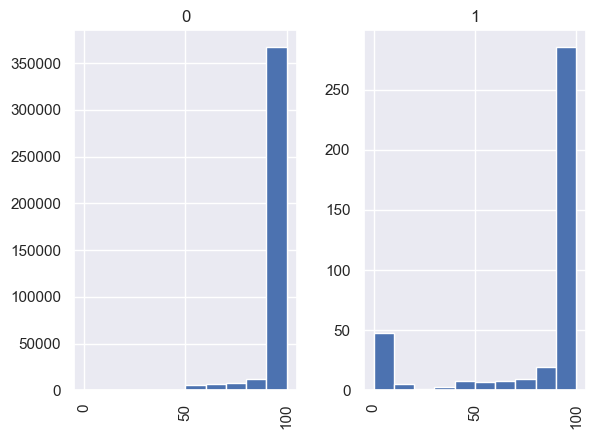

In [ ]:
df['tbp_lv_dnn_lesion_confidence'].hist(by = df['target'])

In [ ]:
df.loc[df['isic_id'] == 'ISIC_2346081']['target']

91807    1
Name: target, dtype: int64

In [ ]:
image_data = h5py.File('train-image.hdf5', 'r')

In [ ]:
img = Image.open((io.BytesIO(np.array(image_data['ISIC_2346081']))))

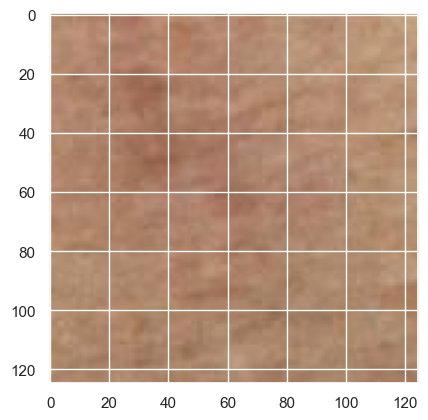

In [ ]:
plt.imshow(img)

In [ ]:
df_positives = df[df['target']==1]

In [ ]:
j = 0

In [ ]:
pos_keys = np.array(df_positives['isic_id']).reshape(-1)

In [ ]:
list = []

In [ ]:
list.append(pos_keys[11])

In [ ]:
list[0]

'ISIC_0287900'

In [ ]:
# rows = 5
# cols = 10

# # Create subplots
# fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# # Plot each image in the corresponding subplot
# for i, ax in enumerate(axes):
#     img = Image.open(io.BytesIO(np.array(image_data[pos_keys[min(j,392)]])))
#     ax.imshow(img, cmap='gray')
#     ax.axis('off')  # Hide axes
#     j+=1

# # Adjust layout to avoid overlapping
# plt.tight_layout()
# plt.show()

In [ ]:
df['tbp_lv_location'].value_counts()

tbp_lv_location
Torso Back Top Third       71112
Torso Front Top Half       63350
Torso Back Middle Third    46185
Left Leg - Lower           27428
Right Leg - Lower          25208
Torso Front Bottom Half    24360
Left Leg - Upper           23673
Right Leg - Upper          23034
Right Arm - Upper          22972
Left Arm - Upper           22816
Head & Neck                12046
Left Arm - Lower           11939
Right Arm - Lower          10636
Unknown                     5756
Torso Back Bottom Third     4596
Left Leg                    1974
Right Leg                   1711
Left Arm                    1593
Right Arm                    601
Torso Front                   60
Torso Back                     9
Name: count, dtype: int64

In [ ]:
pd.crosstab(df['tbp_lv_location'], df['target'])

target,0,1
tbp_lv_location,,
Head & Neck,11968,78
Left Arm,1591,2
Left Arm - Lower,11927,12
Left Arm - Upper,22796,20
Left Leg,1968,6
Left Leg - Lower,27404,24
Left Leg - Upper,23659,14
Right Arm,601,0
Right Arm - Lower,10631,5
